# About
- Get list of youtube videos in the nutrition facts channel
- Download the transcripts of the videos

In [12]:
import os
import pandas as pd

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from googleapiclient.discovery import build
from youtube_transcript_api import YouTubeTranscriptApi
from youtube_transcript_api._errors import TranscriptsDisabled
from dotenv import load_dotenv

# Get api keys
load_dotenv()
YOUTUBE_APIKEY = os.environ['YOUTUBE_APIKEY']
OPENAI_APIKEY = os.environ['OPENAI_APIKEY']

In [2]:
# Initialiaze youtube api client
youtube = build('youtube', 'v3', developerKey=YOUTUBE_APIKEY)

# Get Channel ID and List of Videos + Metadata

In [3]:
# Let's see what's available in the channels list api
#https://developers.google.com/youtube/v3/docs/channels/list
username = 'NutritionFactsOrg'
request = youtube.channels().list(
        part="id",
        forUsername=username
    )
response = request.execute()
response

{'kind': 'youtube#channelListResponse',
 'etag': 'y2wbGNYxO1mQLSW8NgLvKwMoFvQ',
 'pageInfo': {'totalResults': 1, 'resultsPerPage': 5},
 'items': [{'kind': 'youtube#channel',
   'etag': 'QrBFR4pa4iZJUXj0kXL8bnskofE',
   'id': 'UCddn8dUxYdgJz3Qr5mjADtA'}]}

In [4]:
# Let's see what's available in the channels list api
username = 'NutritionFactsOrg'
request = youtube.channels().list(
        part="statistics",
        forUsername=username
    )
response = request.execute()
response

{'kind': 'youtube#channelListResponse',
 'etag': 'bk07A_MmcK-D8v4d6W2F1D19VD8',
 'pageInfo': {'totalResults': 1, 'resultsPerPage': 5},
 'items': [{'kind': 'youtube#channel',
   'etag': '_j4yiMQau7n8ehX3SVIcA0aP4Ag',
   'id': 'UCddn8dUxYdgJz3Qr5mjADtA',
   'statistics': {'viewCount': '240451872',
    'subscriberCount': '1120000',
    'hiddenSubscriberCount': False,
    'videoCount': '2603'}}]}

In [5]:
# Get the channel ID
channel_id = response['items'][0]['id']
channel_id

'UCddn8dUxYdgJz3Qr5mjADtA'

In [6]:
# Get a list of videos in the given channel
response = youtube.channels().list(part='contentDetails', id=channel_id).execute()
playlist_id = response['items'][0]['contentDetails']['relatedPlaylists']['uploads']

# Get a list of videos in the channel's uploads playlist
videos = []
next_page_token = None
while True:
    if next_page_token is None:
        response = youtube.playlistItems().list(part='snippet', playlistId=playlist_id, maxResults=50).execute()
    else:
        response = youtube.playlistItems().list(part='snippet', playlistId=playlist_id, maxResults=50, pageToken=next_page_token).execute()

    for item in response['items']:
        videos.append({
            'videoId': item['snippet']['resourceId']['videoId'],
            'title': item['snippet']['title'],
            'description': item['snippet']['description'],
            'publishedAt': item['snippet']['publishedAt']
        })

    next_page_token = response.get('nextPageToken')
    if next_page_token is None:
        break

# Create a DataFrame from the list of videos
df = pd.DataFrame(videos)

df

,videoId,title,description,publishedAt
0,7niWR9iARhE,Podcast: How to Die a Good Death,"Retaining dignity, privacy, and relief from pa...",2024-04-18T12:59:47Z
1,E-72zyo4wRg,Three Reasons Why Fruits and Vegetables May Re...,Osteoporosis and diet: Even just a single extr...,2024-04-17T11:59:47Z
2,Rr0rKZ3M-CA,Dark green leafy vegetables are packed with lu...,New subscribers to our e-newsletter always rec...,2024-04-16T18:00:14Z
3,SXzVlreNIY4,Benefits and Side Effects of the Shingles Vaccine,How does the new shingles vaccine compare to t...,2024-04-15T11:59:49Z
4,T7WDjPLAzc4,Your challenge this week is to add at least tw...,New subscribers to our e-newsletter always rec...,2024-04-12T22:00:20Z
...,...,...,...,...
2599,P_X3exQtuGA,The Healthiest Herbal Tea,New subscribers to our e-newsletter always rec...,2011-02-08T14:59:42Z
2600,ce-pvksbiwM,Update on Yerba Maté,New subscribers to our e-newsletter always rec...,2011-02-08T14:57:18Z
2601,1Yb5MjU38ng,Update on MSG,New subscribers to our e-newsletter always rec...,2011-02-08T14:48:31Z
2602,lD2RzNJYGxQ,Update on Juice Plus+®,New subscribers to our e-newsletter always rec...,2011-02-08T05:41:12Z


# Get the transcripts

In [7]:
def get_transcript(video_id):
    try:
        transcript_list = YouTubeTranscriptApi.get_transcript(video_id, languages=['en', "English"])
        # Combine the text of all segments into one large string
        transcript_text = ' '.join([segment['text'].replace('\n',' ') for segment in transcript_list])
        return transcript_text
    except Exception as e:
        print(f"Error for video {video_id}: {e}")
        return None

In [18]:
# Get all the transcripts for 2020 - present
df['transcript'] = df['videoId'].apply(get_transcript)
# Save the transcripts
df.to_csv('../data/transcripts_all_2024-04-18')

Error for video Oc8T8OGKnZ8: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=Oc8T8OGKnZ8! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are using and provide the information needed to replicate the error. Also make sure that there are no open issues which already describe your problem!
Error for video P1IGY-UYETE: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=P1IGY-UYETE! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Pl

# Clean Transcripts File

In [19]:
df_transcripts = pd.read_csv('../data/transcripts_all_2024-04-18')
df_transcripts

,Unnamed: 0,videoId,title,description,publishedAt,transcript
0,0,7niWR9iARhE,Podcast: How to Die a Good Death,"Retaining dignity, privacy, and relief from pa...",2024-04-18T12:59:47Z,I hear from lots of people every day who are c...
1,1,E-72zyo4wRg,Three Reasons Why Fruits and Vegetables May Re...,Osteoporosis and diet: Even just a single extr...,2024-04-17T11:59:47Z,"""Three Reasons Fruits and Vegetables May Reduc..."
2,2,Rr0rKZ3M-CA,Dark green leafy vegetables are packed with lu...,New subscribers to our e-newsletter always rec...,2024-04-16T18:00:14Z,here's the rate of cognitive decline in elderl...
3,3,SXzVlreNIY4,Benefits and Side Effects of the Shingles Vaccine,How does the new shingles vaccine compare to t...,2024-04-15T11:59:49Z,"""Benefits and Side Effects of the Shingles Vac..."
4,4,T7WDjPLAzc4,Your challenge this week is to add at least tw...,New subscribers to our e-newsletter always rec...,2024-04-12T22:00:20Z,dark green leafy vegetables are the most nutri...
...,...,...,...,...,...,...
2599,2599,P_X3exQtuGA,The Healthiest Herbal Tea,New subscribers to our e-newsletter always rec...,2011-02-08T14:59:42Z,"""The Healthiest Herbal Tea"" Walking through th..."
2600,2600,ce-pvksbiwM,Update on Yerba Maté,New subscribers to our e-newsletter always rec...,2011-02-08T14:57:18Z,"""Update on Yerba Maté"" And finally, what about..."
2601,2601,1Yb5MjU38ng,Update on MSG,New subscribers to our e-newsletter always rec...,2011-02-08T14:48:31Z,"""Update on MSG"" What about MSG? The scientific..."
2602,2602,lD2RzNJYGxQ,Update on Juice Plus+®,New subscribers to our e-newsletter always rec...,2011-02-08T05:41:12Z,"""Update on Juice Plus+"" What about Juice Plus+..."


In [25]:
# Check nulls
df_transcripts['transcript'].isna().sum()

27

In [26]:
# REmove nulls
df_transcripts = df_transcripts[df_transcripts['transcript'].notna()]
df_transcripts.shape

(2577, 6)

In [18]:
# Instantiate model
model = ChatOpenAI(api_key=OPENAI_APIKEY, model='gpt-4-turbo')

In [28]:
df_transcripts['num_tokens'] = df_transcripts['transcript'].apply(model.get_num_tokens)

/var/folders/wm/nll4dzqx2_n5zxq0y2h84cs40000gn/T/ipykernel_67776/1223576444.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transcripts['num_tokens'] = df_transcripts['transcript'].apply(model.get_num_tokens)


<Axes: >

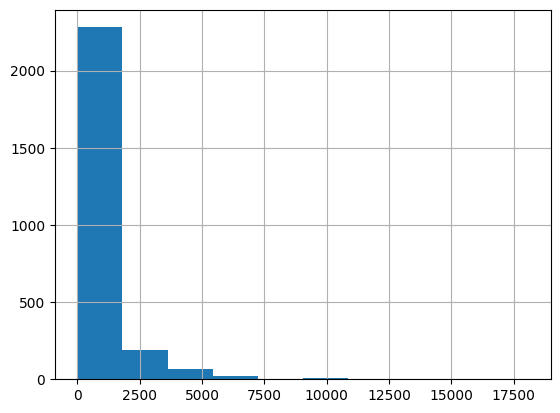

In [30]:
df_transcripts['num_tokens'].hist()

In [31]:
df_transcripts['num_tokens'].describe()

count     2577.000000
mean      1117.038805
std       1308.670582
min          4.000000
25%        569.000000
50%        855.000000
75%       1099.000000
max      18087.000000
Name: num_tokens, dtype: float64

In [32]:
# Save cleaned
# df_transcripts.to_csv('../data/transcripts_all_2024-04-18_cleaned.csv')